In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import wasserstein_distance, ks_2samp

import matplotlib.pyplot as plt

def view_single_distribution(
    df,
    metric="area",
    bins=50,
    density=True,
    ax=None,
    title_prefix=""
):
    """
    View a histogram of a single metric from a DataFrame containing
    columns like: ['video', 'frame', 'area', 'eccentricity', 'solidity', 'perimeter'].

    Args:
        df (pd.DataFrame): The input DataFrame.
        metric (str): Which column to visualize, e.g. 'area', 'eccentricity', 'solidity', 'perimeter'.
        bins (int): Number of histogram bins.
        density (bool): Whether to normalize the histogram (density=True) or show counts (density=False).
        ax (matplotlib.axes.Axes, optional): Matplotlib Axes to plot on. 
            If None, a new figure/axes is created.
        title_prefix (str, optional): An optional prefix added to the plot title (e.g. "Real" or "Generated").

    Returns:
        matplotlib.axes.Axes: The axes on which the histogram was plotted.
    """
    if metric not in df.columns:
        raise ValueError(
            f"Metric '{metric}' not found in DataFrame columns. "
            f"Available columns: {df.columns.tolist()}"
        )

    # Drop any NaN or invalid values
    values = df[metric].dropna()

    # Create new figure/axes if none provided
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))

    # Plot histogram
    ax.hist(values, bins=bins, alpha=0.7, edgecolor="black", density=density)
    ax.set_title(f"{title_prefix} {metric.capitalize()} Distribution")
    ax.set_xlabel(metric)
    ax.set_ylabel("Density" if density else "Count")

    return ax

def compare_distributions_wasserstein(df_real, df_gen, metric):
    """Compute Wasserstein distance for the given metric."""
    real_values = df_real[metric].dropna()
    gen_values  = df_gen[metric].dropna()
    return wasserstein_distance(real_values, gen_values)

def compare_distributions_ks(df_real, df_gen, metric):
    """Compute KS statistic for the given metric."""
    real_values = df_real[metric].dropna()
    gen_values  = df_gen[metric].dropna()
    ks_stat, ks_pval = ks_2samp(real_values, gen_values)
    return ks_stat, ks_pval

def plot_overlaid_histograms(df_real, df_gen, metric, ax, bins=50):
    """Plot two overlaid histograms for the given metric."""
    real_values = df_real[metric].dropna()
    gen_values  = df_gen[metric].dropna()
    ax.hist(real_values, bins=bins, alpha=0.5, label="Real", density=True)
    ax.hist(gen_values,  bins=bins, alpha=0.5, label="Generated", density=True)
    ax.set_xlabel(metric)
    ax.set_ylabel("Density")
    ax.legend()

In [6]:
############################################################
# 1) LOAD PROLIFERATION DATAFRAMES
###########################################################
BASE = "../../results/t2v"
BASE_IDR = f"{BASE}/IDR0013-FILTERED-Test"
END = "all_movement.csv"
dfs = {
    "all": pd.read_csv(f"{BASE_IDR}/{END}"),
    "cc-high": pd.read_csv(f"{BASE_IDR}-cc-HIGH/{END}"),
    "cc-low": pd.read_csv(f"{BASE_IDR}-cc-LOW/{END}"),
    "pr-high": pd.read_csv(f"{BASE_IDR}-pr-HIGH/{END}"),
    "pr-low": pd.read_csv(f"{BASE_IDR}-pr-LOW/{END}"),
    "ms-high": pd.read_csv(f"{BASE_IDR}-ms-HIGH/{END}"),
    "ms-low": pd.read_csv(f"{BASE_IDR}-ms-LOW/{END}"),
    # "prompt_pr_pr-HIGH": pd.read_csv(f"{BASE}/prompt_pr_pr-HIGH/{END}"),
    # "prompt_pr_pr-LOW": pd.read_csv(f"{BASE}/prompt_pr_pr-LOW/{END}"),
    # "prompt_cc_cc-HIGH": pd.read_csv(f"{BASE}/prompt_cc_cc-HIGH/{END}"),
    # "prompt_cc_cc-LOW": pd.read_csv(f"{BASE}/prompt_cc_cc-LOW/{END}"),
    "prompt_ms_ms-HIGH": pd.read_csv(f"{BASE}/prompt_ms_ms-HIGH/{END}"),
    "prompt_ms_ms-LOW": pd.read_csv(f"{BASE}/prompt_ms_ms-LOW/{END}"),
    # "phenotype_alive_alive": pd.read_csv(f"{BASE}/phenotype_alive_alive/{END}"),
    # "phenotype_dead_dead": pd.read_csv(f"{BASE}/phenotype_dead_dead/{END}"),
    # "phenotype_cc_cc-HIGH": pd.read_csv(f"{BASE}/phenotype_cc_cc-HIGH/{END}"),
    # "phenotype_cc_cc-LOW": pd.read_csv(f"{BASE}/phenotype_cc_cc-LOW/{END}"),
    "phenotype_ms_ms-HIGH": pd.read_csv(f"{BASE}/phenotype_ms_ms-HIGH/{END}"),
    "phenotype_ms_ms-LOW": pd.read_csv(f"{BASE}/phenotype_ms_ms-LOW/{END}"),
    "uncond_frames81": pd.read_csv(f"{BASE}/uncond_frames81/{END}"),
    # "phenotype_pr_pr-HIGH": pd.read_csv(f"{BASE}/phenotype_pr_pr-HIGH/{END}"),
    # "phenotype_pr_pr-LOW": pd.read_csv(f"{BASE}/phenotype_pr_pr-LOW/{END}"),
}

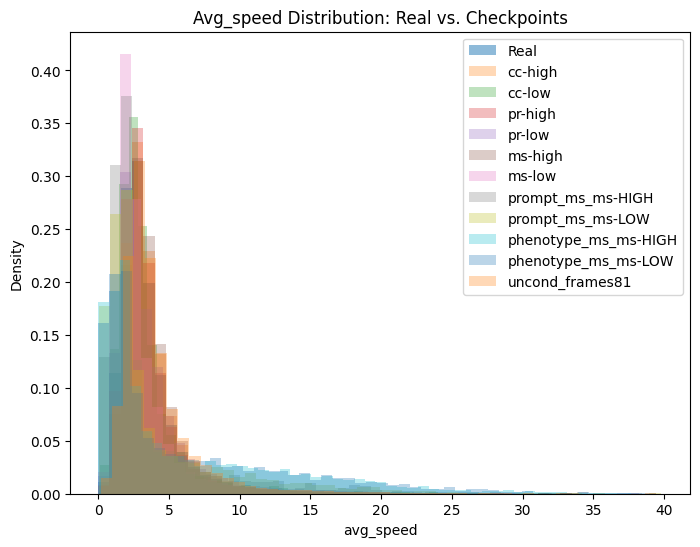

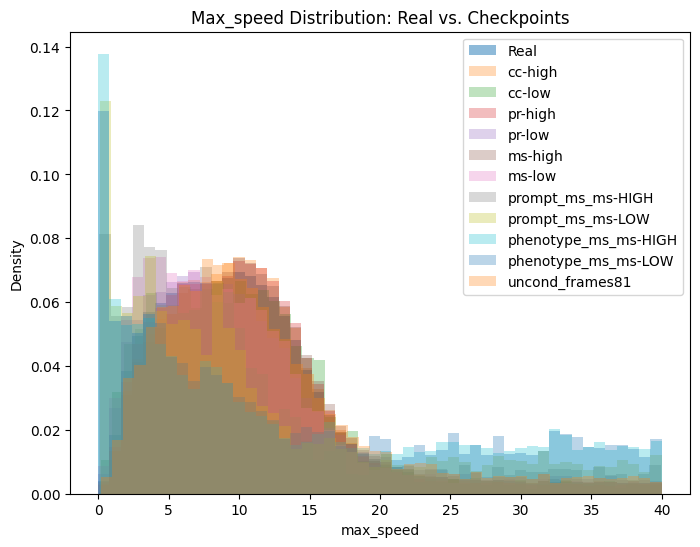

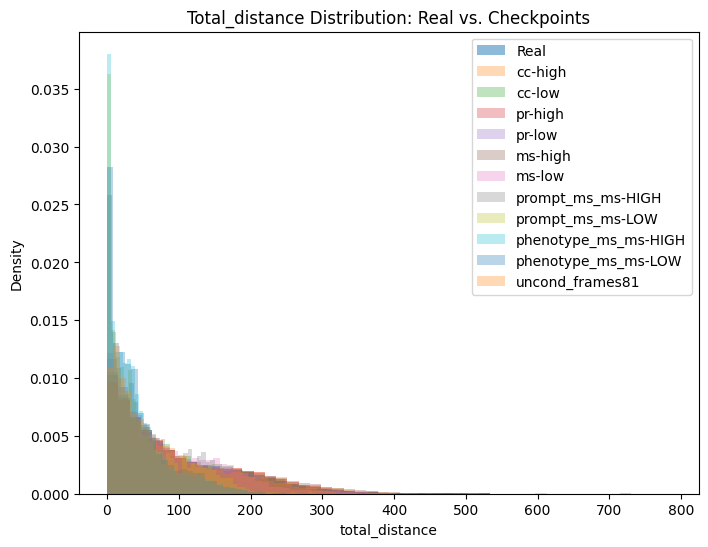

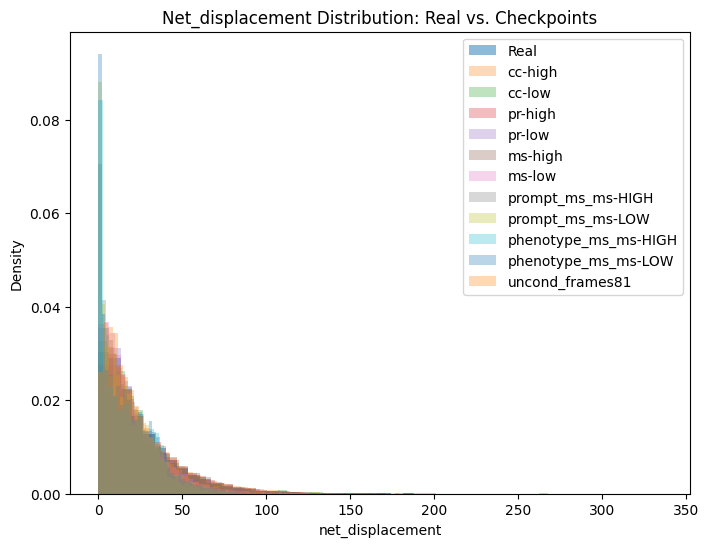

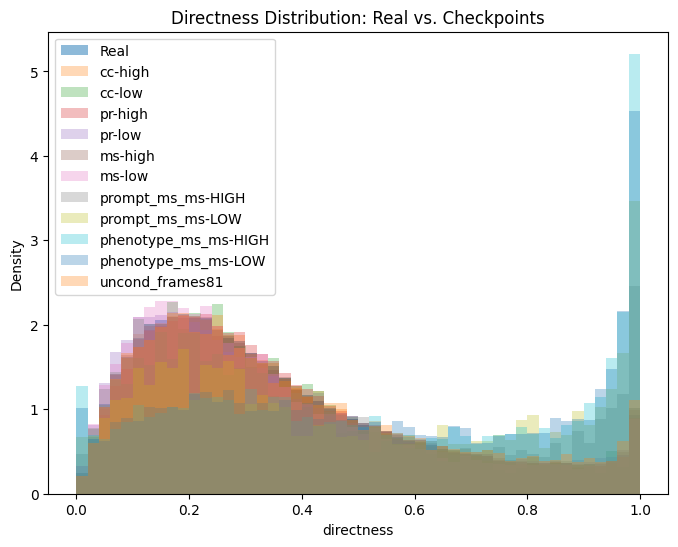

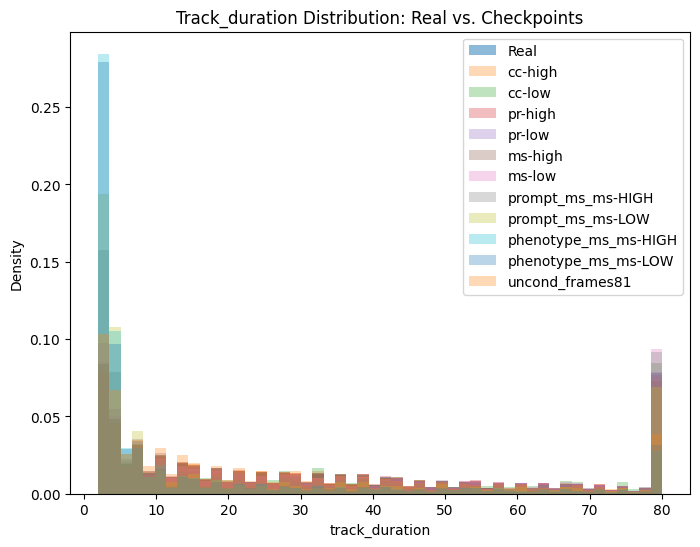

In [9]:
import matplotlib.pyplot as plt

metrics = ['avg_speed', 'max_speed', 'total_distance', 'net_displacement', 'directness', 'track_duration']

for metric in metrics:
    plt.figure(figsize=(8,6))
    # Plot real distribution
    plt.hist(dfs["all"][metric].dropna(), bins=50, alpha=0.5, density=True, label="Real")
    
    # Plot each checkpoint overlayed
    for name, df in dfs.items():
        if name == "all":
            continue
        plt.hist(df[metric].dropna(), bins=50, alpha=0.3, density=True, label=name)
    
    plt.title(f"{metric.capitalize()} Distribution: Real vs. Checkpoints")
    plt.xlabel(metric)
    plt.ylabel("Density")
    plt.legend()
    plt.show()

In [15]:
import pandas as pd
from scipy.stats import wasserstein_distance, ks_2samp


metrics = [
    "net_displacement",
]
key = "ms-high"

results = []

for checkpoint_name, df_gen in dfs.items():
    if checkpoint_name == key:
        continue
    for metric in metrics:
        real_vals = dfs[key][metric].dropna()
        gen_vals  = df_gen[metric].dropna()
        
        wdist  = wasserstein_distance(real_vals, gen_vals)
        ks_stat, ks_pval = ks_2samp(real_vals, gen_vals)
        
        results.append({
            "checkpoint": checkpoint_name,
            "metric": metric,
            "wasserstein_distance": wdist,
            "ks_stat": ks_stat,
            "ks_pval": ks_pval
        })

df_results = pd.DataFrame(results)


for metric in metrics:
    # Filter rows for this metric
    subdf = df_results[df_results["metric"] == metric].copy()
    
    # Sort by wasserstein_distance ascending (lowest distance = best)
    subdf = subdf.sort_values("wasserstein_distance")
    
    print(f"\n=== Ranking for '{metric}' by Wasserstein Distance ===")
    display(subdf[["checkpoint", "metric", "wasserstein_distance"]])


=== Ranking for 'net_displacement' by Wasserstein Distance ===


,checkpoint,metric,wasserstein_distance
1,cc-high,net_displacement,0.384987
3,pr-high,net_displacement,0.617501
0,all,net_displacement,2.099394
2,cc-low,net_displacement,2.298083
4,pr-low,net_displacement,5.420242
10,uncond_frames81,net_displacement,5.915558
5,ms-low,net_displacement,6.490050
9,phenotype_ms_ms-LOW,net_displacement,9.135327
8,phenotype_ms_ms-HIGH,net_displacement,9.643053
6,prompt_ms_ms-HIGH,net_displacement,10.137807


In [16]:
import pandas as pd
from scipy.stats import wasserstein_distance, ks_2samp


metrics = [
    "net_displacement",
]
key = "ms-low"

results = []

for checkpoint_name, df_gen in dfs.items():
    if checkpoint_name == key:
        continue
    for metric in metrics:
        real_vals = dfs[key][metric].dropna()
        gen_vals  = df_gen[metric].dropna()
        
        wdist  = wasserstein_distance(real_vals, gen_vals)
        ks_stat, ks_pval = ks_2samp(real_vals, gen_vals)
        
        results.append({
            "checkpoint": checkpoint_name,
            "metric": metric,
            "wasserstein_distance": wdist,
            "ks_stat": ks_stat,
            "ks_pval": ks_pval
        })

df_results = pd.DataFrame(results)


for metric in metrics:
    # Filter rows for this metric
    subdf = df_results[df_results["metric"] == metric].copy()
    
    # Sort by wasserstein_distance ascending (lowest distance = best)
    subdf = subdf.sort_values("wasserstein_distance")
    
    print(f"\n=== Ranking for '{metric}' by Wasserstein Distance ===")
    display(subdf[["checkpoint", "metric", "wasserstein_distance"]])


=== Ranking for 'net_displacement' by Wasserstein Distance ===


,checkpoint,metric,wasserstein_distance
10,uncond_frames81,net_displacement,0.699481
4,pr-low,net_displacement,1.070118
9,phenotype_ms_ms-LOW,net_displacement,2.645277
8,phenotype_ms_ms-HIGH,net_displacement,3.153003
6,prompt_ms_ms-HIGH,net_displacement,3.647757
7,prompt_ms_ms-LOW,net_displacement,4.033943
2,cc-low,net_displacement,4.210378
0,all,net_displacement,4.390656
3,pr-high,net_displacement,5.874462
1,cc-high,net_displacement,6.160703


In [7]:

for metric in metrics:
    # Filter rows for this metric
    subdf = df_results[df_results["metric"] == metric].copy()
    
    # Sort by wasserstein_distance ascending (lowest distance = best)
    subdf = subdf.sort_values("wasserstein_distance")
    
    print(f"\n=== Ranking for '{metric}' by Wasserstein Distance ===")
    display(subdf[["checkpoint", "metric", "wasserstein_distance"]])


=== Ranking for 'avg_speed' by Wasserstein Distance ===


,checkpoint,metric,wasserstein_distance
84,sft_i2v_500,avg_speed,0.157436
96,sft_i2v_900,avg_speed,0.270992
78,sft_i2v_250,avg_speed,0.450595
90,sft_i2v_750,avg_speed,0.646330
18,r64_750,avg_speed,0.765505
60,r256_375,avg_speed,0.823801
72,r256_900,avg_speed,0.997996
42,r128_750,avg_speed,1.059860
24,r64_900,avg_speed,1.071192
54,r256_250,avg_speed,1.073568



=== Ranking for 'max_speed' by Wasserstein Distance ===


,checkpoint,metric,wasserstein_distance
97,sft_i2v_900,max_speed,0.707482
85,sft_i2v_500,max_speed,0.850027
79,sft_i2v_250,max_speed,1.251074
61,r256_375,max_speed,1.258035
73,r256_900,max_speed,1.277377
19,r64_750,max_speed,1.282654
91,sft_i2v_750,max_speed,1.324188
43,r128_750,max_speed,1.362840
25,r64_900,max_speed,1.425322
55,r256_250,max_speed,1.571489



=== Ranking for 'total_distance' by Wasserstein Distance ===


,checkpoint,metric,wasserstein_distance
98,sft_i2v_900,total_distance,2.469197
44,r128_750,total_distance,2.784226
86,sft_i2v_500,total_distance,6.677328
14,r64_500,total_distance,7.803917
32,r128_250,total_distance,8.500487
38,r128_500,total_distance,9.286236
26,r64_900,total_distance,9.329731
62,r256_375,total_distance,9.542087
20,r64_750,total_distance,10.334121
68,r256_750,total_distance,11.247146



=== Ranking for 'net_displacement' by Wasserstein Distance ===


,checkpoint,metric,wasserstein_distance
99,sft_i2v_900,net_displacement,1.032722
87,sft_i2v_500,net_displacement,1.804522
81,sft_i2v_250,net_displacement,1.831415
93,sft_i2v_750,net_displacement,2.337029
9,r64_250,net_displacement,4.514476
69,r256_750,net_displacement,4.557997
33,r128_250,net_displacement,4.584492
75,r256_900,net_displacement,4.639232
51,r128_900,net_displacement,4.704206
63,r256_375,net_displacement,4.820554



=== Ranking for 'directness' by Wasserstein Distance ===


,checkpoint,metric,wasserstein_distance
100,sft_i2v_900,directness,0.017504
16,r64_500,directness,0.026731
22,r64_750,directness,0.028478
52,r128_900,directness,0.029981
94,sft_i2v_750,directness,0.030768
28,r64_900,directness,0.031623
88,sft_i2v_500,directness,0.033813
76,r256_900,directness,0.035231
46,r128_750,directness,0.035650
40,r128_500,directness,0.046824



=== Ranking for 'track_duration' by Wasserstein Distance ===


,checkpoint,metric,wasserstein_distance
89,sft_i2v_500,track_duration,1.352897
101,sft_i2v_900,track_duration,1.614132
59,r256_250,track_duration,1.676054
95,sft_i2v_750,track_duration,2.384265
65,r256_375,track_duration,3.530358
47,r128_750,track_duration,6.170575
41,r128_500,track_duration,6.717907
29,r64_900,track_duration,7.076901
23,r64_750,track_duration,7.819837
5,baseline,track_duration,8.002384
